<a href="https://colab.research.google.com/github/soundrop199005/colabtest/blob/main/Level1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

● A python script(s) which trains a model from scratch and saves it to a file

● A python script(s) which tests the generated model

● Accompanying documentation on how to run both scripts

● A document that describes the chosen model and structure, and the
result of the model, i.e. several measures of accuracy and performance

# Import Library & Data

In [ ]:
#General imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import progressbar
from __future__ import print_function
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
import gc
# Keras imports
import keras
import random
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.optimizers import *
from tensorflow.keras.utils import to_categorical
import keras.backend as K
import tensorflow as tf
# application (model) imports
from keras import applications
#from keras.applications.inception_v3 import preprocess_input
from keras.layers import Dense
import time
import math
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# import data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

Below is the Cifa class labelled

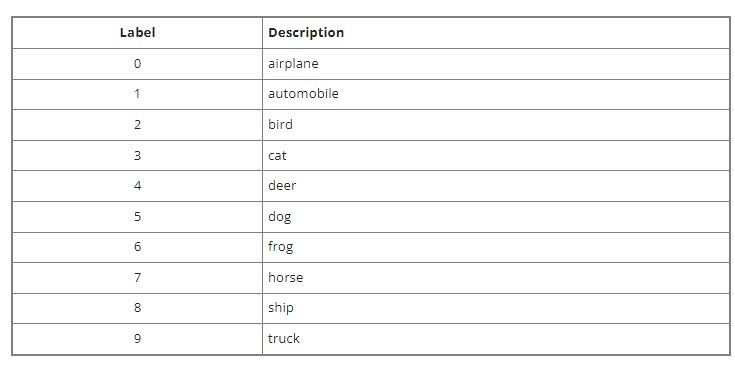

18982
[9]


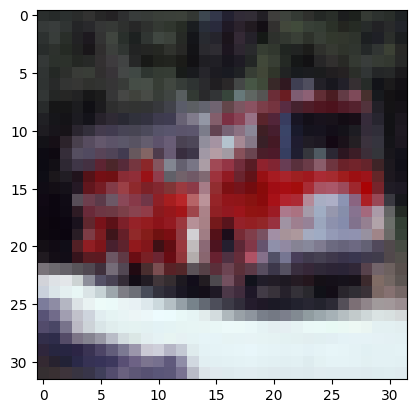

In [ ]:
# sample to have a look

def sample_show(x,y):
  # random generate a number from 0 to length-1
  index_sa = random.randint(0, len(y)-1)
  print(index_sa)
  plt.imshow(x[index_sa])
  print(y[index_sa])

sample_show(x_train, y_train)

7607
[0]


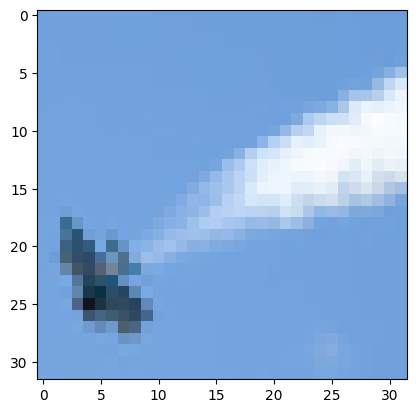

In [ ]:
sample_show(x_test, y_test)

Let's have a look at class imbalance.

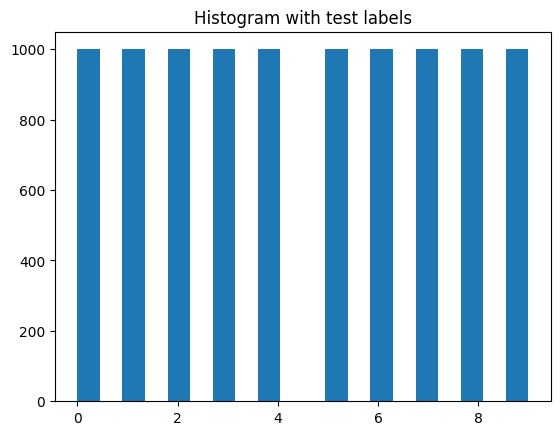

In [ ]:
_ = plt.hist(y_test, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with test labels")
plt.show()

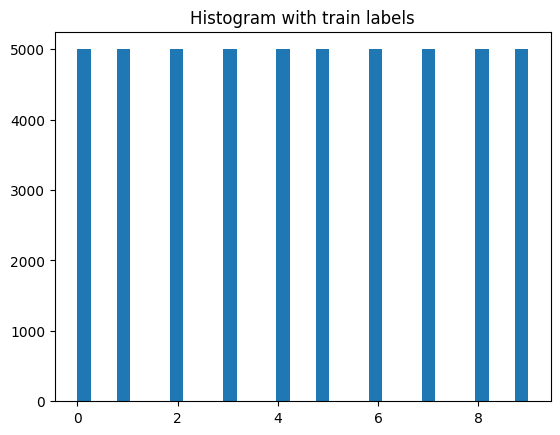

In [ ]:
_ = plt.hist(y_train, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with train labels")
plt.show()

There is not much difference among different classes. Then we can hot encoding the labels and split the validation set from training

In [ ]:
print("First 5 training labels: ", y_train[:5])

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print("First 5 training lables as one-hot encoded vectors:\n", y_train[:5])
print(y_train.shape)
print(y_test.shape)

First 5 training labels:  [[6]
 [9]
 [9]
 [4]
 [1]]
First 5 training lables as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
(50000, 10)
(10000, 10)


In [ ]:
trainX, valX, trainY, valY = train_test_split(x_train, y_train, test_size=0.2, random_state=42, shuffle = True, stratify=y_train)

In [ ]:
[each.shape for each in [trainX, valX, trainY, valY]]

[(40000, 32, 32, 3), (10000, 32, 32, 3), (40000, 10), (10000, 10)]

# Model Selection and Training

## Base Model Candidates

As discussed in the notes, I am using MobileNet as main base model architecture to train the network. Having a look at the parameter number of each basemodel, I found our training sample size is still quite small compared to those default basemodels if we want to train it from scratch.

In [ ]:
base_model_1= applications.MobileNet(
    input_shape=(32,32,3),
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.001,
    include_top=True,
    weights=None,
    input_tensor=None,
    pooling=None,
    classes=10,
    classifier_activation="softmax"
)
base_model_1.summary()

Model: "mobilenet_1.00_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 16, 16, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 16, 16, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 16, 16, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 16, 16, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 16, 16, 32)  

The image size quickly drops to 1 by 1 which makes those deeper layers redundant. I can potentially remove some depth wise, point wise convolution layers. Let's have a look at other networks which have the similar issues.

In [ ]:
base_model_2 = applications.MobileNetV2(
    input_shape=(32,32,3),
    alpha=1.0,
    include_top=True,
    weights= None,
    input_tensor=None,
    pooling=None,
    classes=10,
    classifier_activation="softmax"
)
base_model_2.summary()

Model: "mobilenetv2_1.00_32"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 16, 16, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 16, 16, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 16, 16, 32)           0         ['bn_Conv1[0

When it comes to block_12_add (Add), we can stop it since it is 2*2*96 already. We do not want the dimensions further reduced untill last few layers. Then we can add convolution layers followed by batchnormalization and relu, global average pooling layers, predictions as the last few layers.

In [ ]:
base_model_3 = applications.MobileNetV3Small(
    input_shape=(32,32,3),
    alpha=1.0,
    minimalistic=False,
    include_top=True,
    weights=None,
    input_tensor=None,
    classes=10,
    pooling=None,
    dropout_rate=0.2,
    classifier_activation="softmax",
    include_preprocessing=True,
)
base_model_3.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 32, 32, 3)            0         ['input_3[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 16, 16, 16)           432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 16, 16, 16)           64        ['Conv[0][0]']                
 lization)                                                                         

In [ ]:
gc.collect()

550

In [ ]:
# data augmentation to increase the sample size
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  ])

In [ ]:
# get preprocess to scale input pixels between -1 and 1
preprocess_input = applications.mobilenet_v2.preprocess_input

## Base Model Training

In [ ]:
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

Train the base model from scratch first to see how good it can be

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0045,
    decay_steps=50,
    decay_rate=0.98)

opt = tf.keras.optimizers.experimental.RMSprop(
    learning_rate=lr_schedule,
    rho=0.9,
    momentum=0.9,
    epsilon=1e-07,
    centered=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=100,
    jit_compile=True,
    name='RMSprop'
)

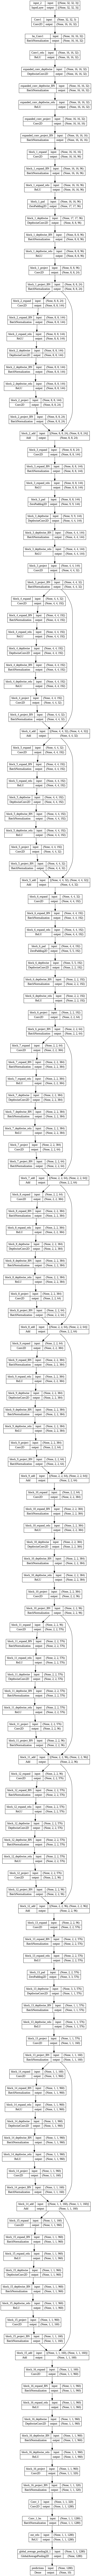

In [ ]:
tf.keras.utils.plot_model(base_model_2, show_shapes=True)

In [ ]:
start = time.time()
# compile model
base_model_2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit model
trainX_ = preprocess_input(trainX)
valX_ = preprocess_input(valX)
history = base_model_2.fit(trainX_, trainY, validation_data=(valX_,valY), epochs=15, verbose=True, batch_size=128, shuffle=True)

Epoch 1/15
313/313 [==============================] - 29s 30ms/step - loss: 2.3263 - accuracy: 0.2022 - val_loss: 17.5832 - val_accuracy: 0.1000
Epoch 2/15
313/313 [==============================] - 8s 26ms/step - loss: 1.6937 - accuracy: 0.3440 - val_loss: 20.3944 - val_accuracy: 0.1232
Epoch 3/15
313/313 [==============================] - 9s 28ms/step - loss: 1.4755 - accuracy: 0.4471 - val_loss: 6.7663 - val_accuracy: 0.2202
Epoch 4/15
313/313 [==============================] - 9s 29ms/step - loss: 1.3485 - accuracy: 0.5049 - val_loss: 6.7193 - val_accuracy: 0.2032
Epoch 5/15
313/313 [==============================] - 9s 28ms/step - loss: 1.2266 - accuracy: 0.5537 - val_loss: 5.8306 - val_accuracy: 0.2412
Epoch 6/15
313/313 [==============================] - 9s 28ms/step - loss: 1.1532 - accuracy: 0.5834 - val_loss: 4.6570 - val_accuracy: 0.2393
Epoch 7/15
313/313 [==============================] - 9s 29ms/step - loss: 1.0702 - accuracy: 0.6150 - val_loss: 4.5884 - val_accuracy: 0.2

436.95749592781067


<Figure size 800x600 with 0 Axes>

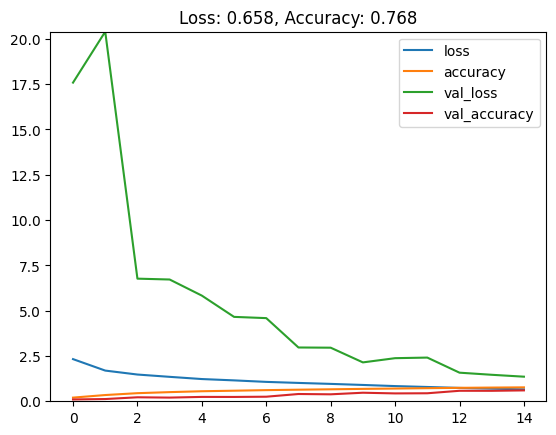

In [ ]:
print(time.time() - start)
plot_loss_accuracy(history)

Generally looks fine. Need to further reduce the learning rate. Also maybe apply some weight decay to minimize the gap between validaiton and training.Maybe apply some data augmentation.

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0045,
    decay_steps=50,
    decay_rate=0.98)

opt = tf.keras.optimizers.experimental.RMSprop(
    learning_rate=lr_schedule,
    rho=0.9,
    momentum=0.9,
    epsilon=1e-07,
    centered=False,
    weight_decay=0.00004,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=100,
    jit_compile=True,
    name='RMSprop'
)

In [ ]:
start = time.time()
# compile model
base_model_2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit model
history = base_model_2.fit(trainX_, trainY, validation_data=(valX_,valY), epochs=50, verbose=True, batch_size=128, shuffle=True)

Epoch 1/50
313/313 [==============================] - 14s 30ms/step - loss: 0.6192 - accuracy: 0.7829 - val_loss: 1.0605 - val_accuracy: 0.6602
Epoch 2/50
313/313 [==============================] - 9s 29ms/step - loss: 0.5764 - accuracy: 0.7964 - val_loss: 1.1106 - val_accuracy: 0.6441
Epoch 3/50
313/313 [==============================] - 10s 31ms/step - loss: 0.5378 - accuracy: 0.8106 - val_loss: 1.0862 - val_accuracy: 0.6567
Epoch 4/50
313/313 [==============================] - 9s 29ms/step - loss: 0.5062 - accuracy: 0.8216 - val_loss: 1.1280 - val_accuracy: 0.6564
Epoch 5/50
313/313 [==============================] - 9s 27ms/step - loss: 0.4707 - accuracy: 0.8344 - val_loss: 1.0457 - val_accuracy: 0.6760
Epoch 6/50
313/313 [==============================] - 9s 29ms/step - loss: 0.4398 - accuracy: 0.8464 - val_loss: 1.0134 - val_accuracy: 0.6813
Epoch 7/50
313/313 [==============================] - 8s 27ms/step - loss: 0.4126 - accuracy: 0.8555 - val_loss: 1.1268 - val_accuracy: 0.66

1485.758067369461


<Figure size 800x600 with 0 Axes>

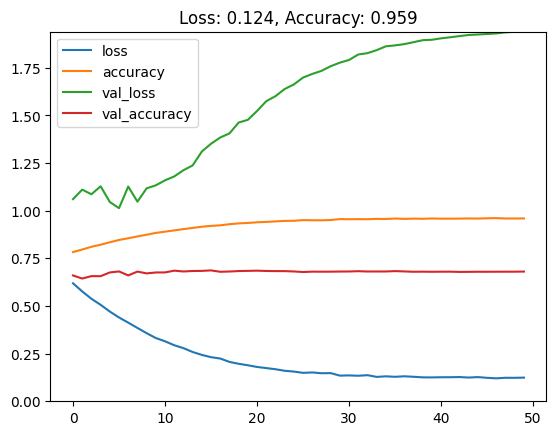

In [ ]:
print(time.time() - start)
plot_loss_accuracy(history)
base_model_2.save('/content/drive/MyDrive/NarrativeTest_SharonXia/base_model_2.keras')

In [ ]:
base_model_2 = tf.keras.models.load_model('/content/drive/MyDrive/NarrativeTest_SharonXia/base_model_2.keras')

Let's try to increase the weight decay.

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0045,
    decay_steps=50,
    decay_rate=0.98)

opt = tf.keras.optimizers.experimental.RMSprop(
    learning_rate=lr_schedule,
    rho=0.9,
    momentum=0.9,
    epsilon=1e-07,
    centered=False,
    weight_decay=0.004,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=100,
    jit_compile=True,
    name='RMSprop'
)

In [ ]:
checkpoint_path = "/content/drive/MyDrive/NarrativeTest_SharonXia/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
n_batches = len(trainY) / 128
n_batches = math.ceil(n_batches)    # round up the number of batches to the nearest whole integer

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=5*n_batches)

In [ ]:
start = time.time()
# compile model
base_model_2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit model
history = base_model_2.fit(trainX_, trainY, validation_data=(valX_,valY), epochs=5, verbose=True, batch_size=128, shuffle=True, callbacks=[cp_callback])

Epoch 1/5
313/313 [==============================] - 31s 34ms/step - loss: 1.1283 - accuracy: 0.6171 - val_loss: 22.0596 - val_accuracy: 0.1179
Epoch 2/5
313/313 [==============================] - 10s 31ms/step - loss: 0.9853 - accuracy: 0.6565 - val_loss: 12.6982 - val_accuracy: 0.2156
Epoch 3/5
313/313 [==============================] - 10s 31ms/step - loss: 0.8921 - accuracy: 0.6889 - val_loss: 9.0241 - val_accuracy: 0.2571
Epoch 4/5
313/313 [==============================] - 9s 30ms/step - loss: 0.8259 - accuracy: 0.7131 - val_loss: 13.4249 - val_accuracy: 0.2008
Epoch 5/5
311/313 [============================>.] - ETA: 0s - loss: 0.7692 - accuracy: 0.7350
Epoch 5: saving model to /content/drive/MyDrive/NarrativeTest_SharonXia/cp-0005.ckpt
313/313 [==============================] - 10s 33ms/step - loss: 0.7685 - accuracy: 0.7351 - val_loss: 5.4157 - val_accuracy: 0.4030


It is obvious that weight decay does not work. According to research, weight decay are not very useful in mobileNet architecture. We can just use the default weight decay recommended in the original paper which is very small already. Now let's try reduce alpha for base model.

In [ ]:
base_model_2_alpha07 = applications.MobileNetV2(
    input_shape=(32,32,3),
    alpha=0.7,
    include_top=True,
    weights= None,
    input_tensor=None,
    pooling=None,
    classes=10,
    classifier_activation="softmax"
)
base_model_2_alpha07.summary()

Model: "mobilenetv2_0.70_32"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_34 (InputLayer)       [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 16, 16, 24)           648       ['input_34[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 16, 16, 24)           96        ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 16, 16, 24)           0         ['bn_Conv1[0

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0045,
    decay_steps=50,
    decay_rate=0.98)

opt = tf.keras.optimizers.experimental.RMSprop(
    learning_rate=lr_schedule,
    rho=0.9,
    momentum=0.9,
    epsilon=1e-07,
    centered=False,
    weight_decay=0.00004,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=100,
    jit_compile=True,
    name='RMSprop'
)

In [ ]:
base_model_2_alpha07
# compile model
base_model_2_alpha07.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit model
history = base_model_2_alpha07.fit(trainX_, trainY, validation_data=(valX_,valY), epochs=5, verbose=True, batch_size=128, shuffle=True, callbacks=[cp_callback])

Epoch 1/5
313/313 [==============================] - 32s 35ms/step - loss: 2.2594 - accuracy: 0.2328 - val_loss: 24.5202 - val_accuracy: 0.1000
Epoch 2/5
313/313 [==============================] - 10s 31ms/step - loss: 1.6307 - accuracy: 0.3672 - val_loss: 17.5216 - val_accuracy: 0.1169
Epoch 3/5
313/313 [==============================] - 9s 30ms/step - loss: 1.4217 - accuracy: 0.4671 - val_loss: 12.2003 - val_accuracy: 0.1203
Epoch 4/5
313/313 [==============================] - 9s 30ms/step - loss: 1.2448 - accuracy: 0.5489 - val_loss: 8.2341 - val_accuracy: 0.1566
Epoch 5/5
311/313 [============================>.] - ETA: 0s - loss: 1.1356 - accuracy: 0.5919
Epoch 5: saving model to /content/drive/MyDrive/NarrativeTest_SharonXia/cp-0005.ckpt
313/313 [==============================] - 10s 32ms/step - loss: 1.1354 - accuracy: 0.5920 - val_loss: 7.7511 - val_accuracy: 0.2170


It seems we are on the right track. Let's train more epochs.

In [ ]:
history = base_model_2_alpha07.fit(trainX_, trainY, validation_data=(valX_,valY), epochs=50, verbose=True, batch_size=128, shuffle=True, callbacks=[cp_callback])

Epoch 1/50
313/313 [==============================] - 10s 31ms/step - loss: 1.0631 - accuracy: 0.6189 - val_loss: 4.9292 - val_accuracy: 0.2966
Epoch 2/50
313/313 [==============================] - 10s 31ms/step - loss: 0.9946 - accuracy: 0.6448 - val_loss: 4.1981 - val_accuracy: 0.3440
Epoch 3/50
313/313 [==============================] - 10s 31ms/step - loss: 0.9453 - accuracy: 0.6601 - val_loss: 3.4526 - val_accuracy: 0.3977
Epoch 4/50
313/313 [==============================] - 10s 33ms/step - loss: 0.8940 - accuracy: 0.6816 - val_loss: 3.9493 - val_accuracy: 0.3866
Epoch 5/50
311/313 [============================>.] - ETA: 0s - loss: 0.8460 - accuracy: 0.6981
Epoch 5: saving model to /content/drive/MyDrive/NarrativeTest_SharonXia/cp-0005.ckpt
313/313 [==============================] - 10s 32ms/step - loss: 0.8461 - accuracy: 0.6979 - val_loss: 4.9689 - val_accuracy: 0.3716
Epoch 6/50
313/313 [==============================] - 10s 30ms/step - loss: 0.8052 - accuracy: 0.7138 - val_lo

<Figure size 800x600 with 0 Axes>

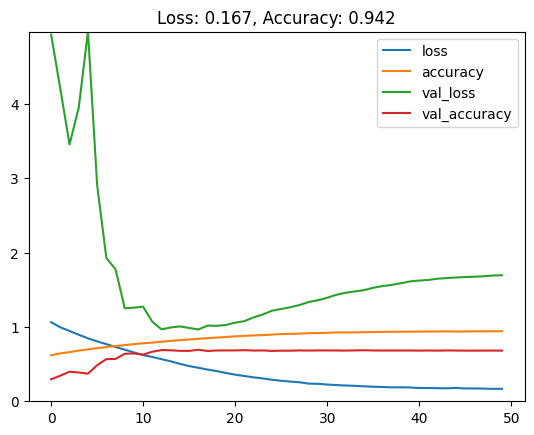

In [ ]:
plot_loss_accuracy(history)

It is slightly better than alpha = 1.

## Hyper Para Tuning

Let's grid search for the best alpha, also further decay the learning rate with early stoppings. I add the L2 norm to the model to avoid overfitting.

In [ ]:
def asem_model(alp,weight_decay) -> keras.Sequential:
# input and preprocess
  inputs = keras.Input(shape=(32, 32, 3))
  preprocess_input = applications.mobilenet_v2.preprocess_input
  x = preprocess_input(inputs)
# use alpha to construct a mobilenetV2 model
  base_model_tune_hyp = applications.MobileNetV2(
  input_shape=(32,32,3),
  alpha=alp,
  include_top=True,
  weights= None,
  input_tensor=None,
  pooling=None,
  classes=10,
  classifier_activation="softmax")
# add weight decay
  alpha = weight_decay  # weight decay coefficient
  for layer in base_model_tune_hyp.layers:
      if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
          layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.kernel))
      if hasattr(layer, 'bias_regularizer') and layer.use_bias:
          layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.bias))
# assemble the model
  y = base_model_tune_hyp(inputs = x)
  model = tf.keras.Model(inputs, y)
  print(model.summary())
  return model


In [ ]:
def plot_loss_accuracy_s(history,filename):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = min(history.history['val_loss'])
    mylist1 = history.history['val_loss']
    ind = mylist1.index(min(mylist1))
    acc =history.history['val_accuracy'][ind]
    plt.title('Val Loss: %.3f, Val Accuracy: %.3f' % (loss, acc))
    plt.savefig(filename)

Wrap up a function for hyper parameter tuning more easily

In [ ]:
def hyp_tuning(alp, lr, m, wd):
  # construct model
  model = asem_model(alp,wd)
  # learning rate schedule
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=lr,
    decay_steps=50,
    decay_rate=0.98)
  # optimizer
  opt = tf.keras.optimizers.experimental.RMSprop(
      learning_rate=lr_schedule,
      rho=0.9,
      momentum=m,
      epsilon=1e-07,
      centered=False,
      # we used weight decay in the model by L2 norm instead
      weight_decay=0,
      clipnorm=None,
      clipvalue=None,
      global_clipnorm=None,
      use_ema=False,
      ema_momentum=0.99,
      ema_overwrite_frequency=100,
      jit_compile=True,
      name='RMSprop'
  )
  parent_dir = '/content/drive/MyDrive/NarrativeTest_SharonXia/base_model_2_alpha_%.3f_lr_%.3f_m_%.2f_wd_%.6f'%(alp,lr,m,wd)
  # os.mkdir(parent_dir)
  if not os.path.exists(parent_dir):
    os.mkdir(parent_dir)
  checkpoint_path = os.path.join(parent_dir, 'model.{epoch:02d}-{val_loss:.2f}.h5')
  print(checkpoint_path)
  my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min'),
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min')]
  # compile model
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  # fit model
  history = model.fit(trainX, trainY, validation_data=(valX,valY), epochs=50, verbose=True, batch_size=64, shuffle=True,callbacks= my_callbacks)
  plot_loss_accuracy_s(history,parent_dir+'.png')
  return min(history.history['val_loss'])

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 tf.math.truediv_10 (TFOpLa  (None, 32, 32, 3)         0         
 mbda)                                                           
                                                                 
 tf.math.subtract_10 (TFOpL  (None, 32, 32, 3)         0         
 ambda)                                                          
                                                                 
 mobilenetv2_0.70_32 (Funct  (None, 10)                1238138   
 ional)                                                          
                                                                 
Total params: 1238138 (4.72 MB)
Trainable params: 1213194 (4.63 MB)
Non-trainable params: 24944 (97.44 KB)
_________________

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 39s 30ms/step - loss: 2.4055 - accuracy: 0.1720 - val_loss: 2.3501 - val_accuracy: 0.1000
Epoch 2/50
625/625 [==============================] - 17s 27ms/step - loss: 2.0439 - accuracy: 0.2408 - val_loss: 2.5503 - val_accuracy: 0.1000
Epoch 3/50
625/625 [==============================] - 16s 26ms/step - loss: 1.5982 - accuracy: 0.3936 - val_loss: 2.5226 - val_accuracy: 0.1163
Epoch 4/50
625/625 [==============================] - 16s 26ms/step - loss: 1.3842 - accuracy: 0.4949 - val_loss: 2.6350 - val_accuracy: 0.1409
Epoch 5/50
625/625 [==============================] - 16s 25ms/step - loss: 1.2314 - accuracy: 0.5646 - val_loss: 2.5841 - val_accuracy: 0.2045
Epoch 6/50
625/625 [==============================] - 17s 27ms/step - loss: 1.1333 - accuracy: 0.6026 - val_loss: 1.9631 - val_accuracy: 0.2980
Epoch 7/50
625/625 [==============================] - 17s 27ms/step - loss: 1.0537 - accuracy: 0.6336 - val_loss: 1.5023 - val_accuracy: 0.4895
Epo

1.0018739700317383

<Figure size 800x600 with 0 Axes>

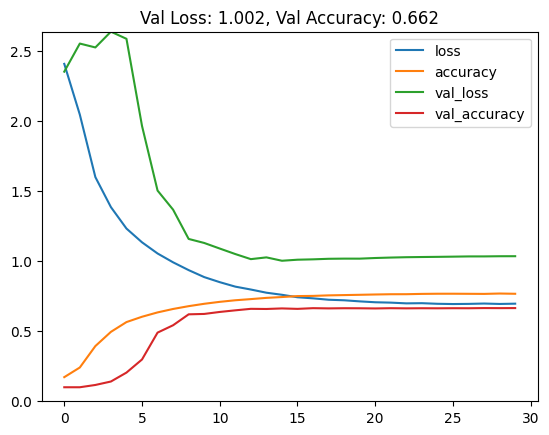

In [ ]:
hyp_tuning(alp = 0.7 ,lr = 0.0005,m = 0.9,wd = 0.00001)

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_67 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 tf.math.truediv_32 (TFOpLa  (None, 32, 32, 3)         0         
 mbda)                                                           
                                                                 
 tf.math.subtract_32 (TFOpL  (None, 32, 32, 3)         0         
 ambda)                                                          
                                                                 
 mobilenetv2_0.50_32 (Funct  (None, 10)                719034    
 ional)                                                          
                                                                 
Total params: 719034 (2.74 MB)
Trainable params: 700490 (2.67 MB)
Non-trainable params: 18544 (72.44 KB)
___________________

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 38s 26ms/step - loss: 2.0367 - accuracy: 0.2575 - val_loss: 2.3129 - val_accuracy: 0.1000
Epoch 2/50
625/625 [==============================] - 15s 24ms/step - loss: 1.6337 - accuracy: 0.4045 - val_loss: 2.3573 - val_accuracy: 0.1000
Epoch 3/50
625/625 [==============================] - 15s 24ms/step - loss: 1.4590 - accuracy: 0.4724 - val_loss: 2.3826 - val_accuracy: 0.1000
Epoch 4/50
625/625 [==============================] - 15s 24ms/step - loss: 1.3528 - accuracy: 0.5100 - val_loss: 2.3871 - val_accuracy: 0.1000
Epoch 5/50
625/625 [==============================] - 15s 24ms/step - loss: 1.2673 - accuracy: 0.5440 - val_loss: 2.3660 - val_accuracy: 0.1000
Epoch 6/50
625/625 [==============================] - 15s 24ms/step - loss: 1.2042 - accuracy: 0.5658 - val_loss: 2.3548 - val_accuracy: 0.1000
Epoch 7/50
625/625 [==============================] - 15s 24ms/step - loss: 1.1490 - accuracy: 0.5873 - val_loss: 2.3429 - val_accuracy: 0.1000
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 39s 29ms/step - loss: 2.0692 - accuracy: 0.2395 - val_loss: 2.3202 - val_accuracy: 0.1000
Epoch 2/50
625/625 [==============================] - 16s 25ms/step - loss: 1.6417 - accuracy: 0.3941 - val_loss: 2.3732 - val_accuracy: 0.1000
Epoch 3/50
625/625 [==============================] - 15s 25ms/step - loss: 1.4974 - accuracy: 0.4565 - val_loss: 2.3813 - val_accuracy: 0.1000
Epoch 4/50
625/625 [==============================] - 15s 24ms/step - loss: 1.4040 - accuracy: 0.4960 - val_loss: 2.3940 - val_accuracy: 0.1000
Epoch 5/50
625/625 [==============================] - 15s 25ms/step - loss: 1.3201 - accuracy: 0.5283 - val_loss: 2.4351 - val_accuracy: 0.1000
Epoch 6/50
625/625 [==============================] - 15s 24ms/step - loss: 1.2561 - accuracy: 0.5511 - val_loss: 2.4072 - val_accuracy: 0.1000
Epoch 7/50
625/625 [==============================] - 15s 24ms/step - loss: 1.2034 - accuracy: 0.5720 - val_loss: 2.4595 - val_accuracy: 0.1000
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 37s 26ms/step - loss: 2.2582 - accuracy: 0.2055 - val_loss: 2.3346 - val_accuracy: 0.1000
Epoch 2/50
625/625 [==============================] - 15s 23ms/step - loss: 1.9838 - accuracy: 0.2627 - val_loss: 2.3465 - val_accuracy: 0.1197
Epoch 3/50
625/625 [==============================] - 14s 23ms/step - loss: 1.7421 - accuracy: 0.3372 - val_loss: 2.4785 - val_accuracy: 0.1000
Epoch 4/50
625/625 [==============================] - 15s 23ms/step - loss: 1.5740 - accuracy: 0.4059 - val_loss: 2.4369 - val_accuracy: 0.1220
Epoch 5/50
625/625 [==============================] - 15s 25ms/step - loss: 1.4502 - accuracy: 0.4584 - val_loss: 2.1567 - val_accuracy: 0.1881
Epoch 6/50
625/625 [==============================] - 15s 24ms/step - loss: 1.3638 - accuracy: 0.5012 - val_loss: 1.8644 - val_accuracy: 0.3226
Epoch 7/50
625/625 [==============================] - 15s 25ms/step - loss: 1.2788 - accuracy: 0.5373 - val_loss: 1.6246 - val_accuracy: 0.4385
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 37s 27ms/step - loss: 2.2787 - accuracy: 0.2032 - val_loss: 2.3795 - val_accuracy: 0.1000
Epoch 2/50
625/625 [==============================] - 15s 25ms/step - loss: 1.8705 - accuracy: 0.3025 - val_loss: 2.6001 - val_accuracy: 0.1000
Epoch 3/50
625/625 [==============================] - 15s 25ms/step - loss: 1.6304 - accuracy: 0.3889 - val_loss: 2.8892 - val_accuracy: 0.1000
Epoch 4/50
625/625 [==============================] - 16s 26ms/step - loss: 1.4911 - accuracy: 0.4505 - val_loss: 2.7891 - val_accuracy: 0.1093
Epoch 5/50
625/625 [==============================] - 16s 26ms/step - loss: 1.3789 - accuracy: 0.4996 - val_loss: 2.3014 - val_accuracy: 0.1578
Epoch 6/50
625/625 [==============================] - 17s 28ms/step - loss: 1.2742 - accuracy: 0.5462 - val_loss: 1.9377 - val_accuracy: 0.2896
Epoch 7/50
625/625 [==============================] - 16s 26ms/step - loss: 1.1955 - accuracy: 0.5768 - val_loss: 1.6424 - val_accuracy: 0.4079
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 37s 27ms/step - loss: 2.3789 - accuracy: 0.1214 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 2/50
625/625 [==============================] - 15s 24ms/step - loss: 2.3135 - accuracy: 0.1336 - val_loss: 2.3044 - val_accuracy: 0.1000
Epoch 3/50
625/625 [==============================] - 15s 24ms/step - loss: 2.2671 - accuracy: 0.1527 - val_loss: 2.3061 - val_accuracy: 0.1000
Epoch 4/50
625/625 [==============================] - 15s 24ms/step - loss: 2.2226 - accuracy: 0.1717 - val_loss: 2.3127 - val_accuracy: 0.1000
Epoch 5/50
625/625 [==============================] - 15s 24ms/step - loss: 2.1822 - accuracy: 0.1835 - val_loss: 2.3193 - val_accuracy: 0.1000
Epoch 6/50
625/625 [==============================] - 15s 24ms/step - loss: 2.1440 - accuracy: 0.2003 - val_loss: 2.3212 - val_accuracy: 0.1000
Epoch 7/50
625/625 [==============================] - 15s 24ms/step - loss: 2.1175 - accuracy: 0.2074 - val_loss: 2.3225 - val_accuracy: 0.1000
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 39s 29ms/step - loss: 2.3792 - accuracy: 0.1208 - val_loss: 2.3099 - val_accuracy: 0.1000
Epoch 2/50
625/625 [==============================] - 16s 25ms/step - loss: 2.3070 - accuracy: 0.1403 - val_loss: 2.3119 - val_accuracy: 0.1000
Epoch 3/50
625/625 [==============================] - 16s 25ms/step - loss: 2.2664 - accuracy: 0.1539 - val_loss: 2.3167 - val_accuracy: 0.1000
Epoch 4/50
625/625 [==============================] - 16s 26ms/step - loss: 2.2387 - accuracy: 0.1677 - val_loss: 2.3218 - val_accuracy: 0.1000
Epoch 5/50
625/625 [==============================] - 16s 25ms/step - loss: 2.2088 - accuracy: 0.1764 - val_loss: 2.3259 - val_accuracy: 0.1000
Epoch 6/50
625/625 [==============================] - 16s 25ms/step - loss: 2.1870 - accuracy: 0.1865 - val_loss: 2.3283 - val_accuracy: 0.1000
Epoch 7/50
625/625 [==============================] - 16s 26ms/step - loss: 2.1681 - accuracy: 0.1971 - val_loss: 2.3380 - val_accuracy: 0.1000
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 38s 28ms/step - loss: 2.1937 - accuracy: 0.1974 - val_loss: 2.3075 - val_accuracy: 0.1000
Epoch 2/50
625/625 [==============================] - 15s 24ms/step - loss: 1.7277 - accuracy: 0.3524 - val_loss: 2.3573 - val_accuracy: 0.1000
Epoch 3/50
625/625 [==============================] - 15s 24ms/step - loss: 1.5663 - accuracy: 0.4253 - val_loss: 2.3684 - val_accuracy: 0.1000
Epoch 4/50
625/625 [==============================] - 15s 25ms/step - loss: 1.4659 - accuracy: 0.4648 - val_loss: 2.3657 - val_accuracy: 0.1000
Epoch 5/50
625/625 [==============================] - 15s 24ms/step - loss: 1.3860 - accuracy: 0.4974 - val_loss: 2.3514 - val_accuracy: 0.1000
Epoch 6/50
625/625 [==============================] - 15s 24ms/step - loss: 1.3359 - accuracy: 0.5168 - val_loss: 2.3765 - val_accuracy: 0.1000
Epoch 7/50
625/625 [==============================] - 15s 25ms/step - loss: 1.2858 - accuracy: 0.5356 - val_loss: 2.3785 - val_accuracy: 0.1000
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 38s 28ms/step - loss: 2.2645 - accuracy: 0.1703 - val_loss: 2.3184 - val_accuracy: 0.1000
Epoch 2/50
625/625 [==============================] - 15s 25ms/step - loss: 1.7939 - accuracy: 0.3333 - val_loss: 2.3720 - val_accuracy: 0.1000
Epoch 3/50
625/625 [==============================] - 15s 25ms/step - loss: 1.5855 - accuracy: 0.4151 - val_loss: 2.3847 - val_accuracy: 0.1000
Epoch 4/50
625/625 [==============================] - 16s 25ms/step - loss: 1.4790 - accuracy: 0.4593 - val_loss: 2.3888 - val_accuracy: 0.1000
Epoch 5/50
625/625 [==============================] - 16s 25ms/step - loss: 1.3992 - accuracy: 0.4907 - val_loss: 2.4348 - val_accuracy: 0.1000
Epoch 6/50
625/625 [==============================] - 16s 25ms/step - loss: 1.3438 - accuracy: 0.5121 - val_loss: 2.4501 - val_accuracy: 0.1000
Epoch 7/50
625/625 [==============================] - 16s 25ms/step - loss: 1.3050 - accuracy: 0.5290 - val_loss: 2.4477 - val_accuracy: 0.1002
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 36s 26ms/step - loss: 1.9537 - accuracy: 0.2819 - val_loss: 2.3174 - val_accuracy: 0.1000
Epoch 2/50
625/625 [==============================] - 15s 25ms/step - loss: 1.5261 - accuracy: 0.4396 - val_loss: 2.3169 - val_accuracy: 0.1000
Epoch 3/50
625/625 [==============================] - 15s 24ms/step - loss: 1.3581 - accuracy: 0.5107 - val_loss: 2.3359 - val_accuracy: 0.1000
Epoch 4/50
625/625 [==============================] - 15s 23ms/step - loss: 1.2294 - accuracy: 0.5590 - val_loss: 2.3459 - val_accuracy: 0.1000
Epoch 5/50
625/625 [==============================] - 15s 24ms/step - loss: 1.1366 - accuracy: 0.5942 - val_loss: 2.3549 - val_accuracy: 0.1000
Epoch 6/50
625/625 [==============================] - 15s 24ms/step - loss: 1.0568 - accuracy: 0.6232 - val_loss: 2.3545 - val_accuracy: 0.1000
Epoch 7/50
625/625 [==============================] - 15s 23ms/step - loss: 0.9920 - accuracy: 0.6435 - val_loss: 2.3334 - val_accuracy: 0.1019
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 39s 27ms/step - loss: 1.9974 - accuracy: 0.2667 - val_loss: 2.3424 - val_accuracy: 0.1000
Epoch 2/50
625/625 [==============================] - 15s 24ms/step - loss: 1.5706 - accuracy: 0.4193 - val_loss: 2.4786 - val_accuracy: 0.1000
Epoch 3/50
625/625 [==============================] - 16s 25ms/step - loss: 1.3840 - accuracy: 0.4986 - val_loss: 2.4752 - val_accuracy: 0.1000
Epoch 4/50
625/625 [==============================] - 15s 25ms/step - loss: 1.2578 - accuracy: 0.5492 - val_loss: 2.4769 - val_accuracy: 0.1000
Epoch 5/50
625/625 [==============================] - 15s 25ms/step - loss: 1.1601 - accuracy: 0.5844 - val_loss: 2.4801 - val_accuracy: 0.1000
Epoch 6/50
625/625 [==============================] - 15s 24ms/step - loss: 1.0832 - accuracy: 0.6163 - val_loss: 2.5112 - val_accuracy: 0.1000
Epoch 7/50
625/625 [==============================] - 16s 25ms/step - loss: 1.0161 - accuracy: 0.6377 - val_loss: 2.5417 - val_accuracy: 0.1000
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 38s 26ms/step - loss: 2.3003 - accuracy: 0.1922 - val_loss: 2.3686 - val_accuracy: 0.1000
Epoch 2/50
625/625 [==============================] - 14s 23ms/step - loss: 1.9972 - accuracy: 0.2602 - val_loss: 2.3873 - val_accuracy: 0.1000
Epoch 3/50
625/625 [==============================] - 15s 24ms/step - loss: 1.7186 - accuracy: 0.3687 - val_loss: 2.4454 - val_accuracy: 0.1063
Epoch 4/50
625/625 [==============================] - 15s 24ms/step - loss: 1.4859 - accuracy: 0.4528 - val_loss: 2.4324 - val_accuracy: 0.1334
Epoch 5/50
625/625 [==============================] - 15s 24ms/step - loss: 1.3570 - accuracy: 0.5015 - val_loss: 2.0761 - val_accuracy: 0.1923
Epoch 6/50
625/625 [==============================] - 15s 25ms/step - loss: 1.2632 - accuracy: 0.5369 - val_loss: 1.7743 - val_accuracy: 0.3122
Epoch 7/50
625/625 [==============================] - 15s 24ms/step - loss: 1.1856 - accuracy: 0.5690 - val_loss: 1.5978 - val_accuracy: 0.3907
Epo

<ipython-input-12-8f315e5bd7f0>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))


Model: "model_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_89 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 tf.math.truediv_43 (TFOpLa  (None, 32, 32, 3)         0         
 mbda)                                                           
                                                                 
 tf.math.subtract_43 (TFOpL  (None, 32, 32, 3)         0         
 ambda)                                                          
                                                                 
 mobilenetv2_0.70_32 (Funct  (None, 10)                1238138   
 ional)                                                          
                                                                 
Total params: 1238138 (4.72 MB)
Trainable params: 1213194 (4.63 MB)
Non-trainable params: 24944 (97.44 KB)
_________________

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 39s 28ms/step - loss: 2.2633 - accuracy: 0.1887 - val_loss: 2.3496 - val_accuracy: 0.1000
Epoch 2/50
625/625 [==============================] - 15s 24ms/step - loss: 1.9812 - accuracy: 0.2615 - val_loss: 2.3805 - val_accuracy: 0.1000
Epoch 3/50
625/625 [==============================] - 15s 25ms/step - loss: 1.7528 - accuracy: 0.3426 - val_loss: 2.4810 - val_accuracy: 0.1006
Epoch 4/50
625/625 [==============================] - 16s 25ms/step - loss: 1.5245 - accuracy: 0.4220 - val_loss: 2.2248 - val_accuracy: 0.1914
Epoch 5/50
625/625 [==============================] - 16s 25ms/step - loss: 1.3616 - accuracy: 0.5021 - val_loss: 2.0285 - val_accuracy: 0.2063
Epoch 6/50
625/625 [==============================] - 16s 25ms/step - loss: 1.2540 - accuracy: 0.5475 - val_loss: 1.8582 - val_accuracy: 0.2821
Epoch 7/50
625/625 [==============================] - 16s 25ms/step - loss: 1.1643 - accuracy: 0.5891 - val_loss: 1.5866 - val_accuracy: 0.4214
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 39s 28ms/step - loss: 2.3576 - accuracy: 0.1325 - val_loss: 2.3030 - val_accuracy: 0.1000
Epoch 2/50
625/625 [==============================] - 15s 25ms/step - loss: 2.2208 - accuracy: 0.1761 - val_loss: 2.3043 - val_accuracy: 0.1000
Epoch 3/50
625/625 [==============================] - 15s 24ms/step - loss: 2.1162 - accuracy: 0.2173 - val_loss: 2.3068 - val_accuracy: 0.1000
Epoch 4/50
625/625 [==============================] - 15s 24ms/step - loss: 2.0354 - accuracy: 0.2451 - val_loss: 2.3150 - val_accuracy: 0.1000
Epoch 5/50
625/625 [==============================] - 16s 25ms/step - loss: 1.9748 - accuracy: 0.2677 - val_loss: 2.3197 - val_accuracy: 0.1000
Epoch 6/50
625/625 [==============================] - 16s 25ms/step - loss: 1.9272 - accuracy: 0.2856 - val_loss: 2.3221 - val_accuracy: 0.1000
Epoch 7/50
625/625 [==============================] - 16s 25ms/step - loss: 1.8887 - accuracy: 0.2999 - val_loss: 2.3280 - val_accuracy: 0.1000
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 40s 30ms/step - loss: 2.3677 - accuracy: 0.1331 - val_loss: 2.3099 - val_accuracy: 0.1000
Epoch 2/50
625/625 [==============================] - 17s 27ms/step - loss: 2.2524 - accuracy: 0.1702 - val_loss: 2.3102 - val_accuracy: 0.1000
Epoch 3/50
625/625 [==============================] - 16s 26ms/step - loss: 2.1589 - accuracy: 0.2067 - val_loss: 2.3144 - val_accuracy: 0.1000
Epoch 4/50
625/625 [==============================] - 17s 27ms/step - loss: 2.0778 - accuracy: 0.2348 - val_loss: 2.3215 - val_accuracy: 0.1000
Epoch 5/50
625/625 [==============================] - 16s 26ms/step - loss: 2.0147 - accuracy: 0.2549 - val_loss: 2.3259 - val_accuracy: 0.1000
Epoch 6/50
625/625 [==============================] - 17s 26ms/step - loss: 1.9716 - accuracy: 0.2713 - val_loss: 2.3367 - val_accuracy: 0.1000
Epoch 7/50
625/625 [==============================] - 17s 26ms/step - loss: 1.9329 - accuracy: 0.2876 - val_loss: 2.3453 - val_accuracy: 0.1000
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 39s 29ms/step - loss: 2.0634 - accuracy: 0.2410 - val_loss: 2.3116 - val_accuracy: 0.1000
Epoch 2/50
625/625 [==============================] - 16s 26ms/step - loss: 1.6166 - accuracy: 0.4029 - val_loss: 2.3597 - val_accuracy: 0.1000
Epoch 3/50
625/625 [==============================] - 16s 25ms/step - loss: 1.4416 - accuracy: 0.4721 - val_loss: 2.3675 - val_accuracy: 0.1000
Epoch 4/50
625/625 [==============================] - 16s 25ms/step - loss: 1.3337 - accuracy: 0.5171 - val_loss: 2.3672 - val_accuracy: 0.1000
Epoch 5/50
625/625 [==============================] - 16s 25ms/step - loss: 1.2419 - accuracy: 0.5503 - val_loss: 2.4010 - val_accuracy: 0.1000
Epoch 6/50
625/625 [==============================] - 16s 26ms/step - loss: 1.1727 - accuracy: 0.5772 - val_loss: 2.4146 - val_accuracy: 0.1000
Epoch 7/50
625/625 [==============================] - 16s 25ms/step - loss: 1.1046 - accuracy: 0.6017 - val_loss: 2.4134 - val_accuracy: 0.1000
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 39s 29ms/step - loss: 2.1704 - accuracy: 0.2119 - val_loss: 2.3154 - val_accuracy: 0.1000
Epoch 2/50
625/625 [==============================] - 17s 27ms/step - loss: 1.6293 - accuracy: 0.4045 - val_loss: 2.3279 - val_accuracy: 0.1000
Epoch 3/50
625/625 [==============================] - 16s 26ms/step - loss: 1.4331 - accuracy: 0.4793 - val_loss: 2.3743 - val_accuracy: 0.1000
Epoch 4/50
625/625 [==============================] - 16s 26ms/step - loss: 1.3115 - accuracy: 0.5254 - val_loss: 2.3595 - val_accuracy: 0.1000
Epoch 5/50
625/625 [==============================] - 16s 26ms/step - loss: 1.2169 - accuracy: 0.5635 - val_loss: 2.3741 - val_accuracy: 0.1000
Epoch 6/50
625/625 [==============================] - 17s 26ms/step - loss: 1.1430 - accuracy: 0.5892 - val_loss: 2.3743 - val_accuracy: 0.1000
Epoch 7/50
625/625 [==============================] - 17s 27ms/step - loss: 1.0845 - accuracy: 0.6141 - val_loss: 2.3876 - val_accuracy: 0.1000
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 40s 29ms/step - loss: 1.8589 - accuracy: 0.3166 - val_loss: 2.3346 - val_accuracy: 0.1000
Epoch 2/50
625/625 [==============================] - 16s 26ms/step - loss: 1.4450 - accuracy: 0.4780 - val_loss: 2.4020 - val_accuracy: 0.1000
Epoch 3/50
625/625 [==============================] - 16s 26ms/step - loss: 1.2400 - accuracy: 0.5586 - val_loss: 2.4249 - val_accuracy: 0.1000
Epoch 4/50
625/625 [==============================] - 16s 26ms/step - loss: 1.0974 - accuracy: 0.6112 - val_loss: 2.4270 - val_accuracy: 0.1000
Epoch 5/50
625/625 [==============================] - 16s 26ms/step - loss: 0.9896 - accuracy: 0.6510 - val_loss: 2.4610 - val_accuracy: 0.1000
Epoch 6/50
625/625 [==============================] - 16s 26ms/step - loss: 0.8968 - accuracy: 0.6824 - val_loss: 2.4745 - val_accuracy: 0.1000
Epoch 7/50
625/625 [==============================] - 16s 26ms/step - loss: 0.8162 - accuracy: 0.7088 - val_loss: 2.4415 - val_accuracy: 0.1000
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 39s 29ms/step - loss: 1.8696 - accuracy: 0.3110 - val_loss: 2.3479 - val_accuracy: 0.1000
Epoch 2/50
625/625 [==============================] - 16s 26ms/step - loss: 1.4519 - accuracy: 0.4718 - val_loss: 2.3590 - val_accuracy: 0.1000
Epoch 3/50
625/625 [==============================] - 16s 26ms/step - loss: 1.2588 - accuracy: 0.5483 - val_loss: 2.3797 - val_accuracy: 0.1000
Epoch 4/50
625/625 [==============================] - 16s 26ms/step - loss: 1.1288 - accuracy: 0.5976 - val_loss: 2.3749 - val_accuracy: 0.1000
Epoch 5/50
625/625 [==============================] - 16s 26ms/step - loss: 1.0243 - accuracy: 0.6362 - val_loss: 2.3896 - val_accuracy: 0.1000
Epoch 6/50
625/625 [==============================] - 16s 26ms/step - loss: 0.9321 - accuracy: 0.6705 - val_loss: 2.4237 - val_accuracy: 0.1000
Epoch 7/50
625/625 [==============================] - 16s 26ms/step - loss: 0.8512 - accuracy: 0.6999 - val_loss: 2.4500 - val_accuracy: 0.1000
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 40s 28ms/step - loss: 2.2720 - accuracy: 0.1875 - val_loss: 2.3582 - val_accuracy: 0.1000
Epoch 2/50
625/625 [==============================] - 16s 25ms/step - loss: 2.0723 - accuracy: 0.2120 - val_loss: 2.4591 - val_accuracy: 0.1000
Epoch 3/50
625/625 [==============================] - 16s 25ms/step - loss: 1.8477 - accuracy: 0.2898 - val_loss: 2.5848 - val_accuracy: 0.1027
Epoch 4/50
625/625 [==============================] - 16s 25ms/step - loss: 1.6229 - accuracy: 0.3845 - val_loss: 2.5644 - val_accuracy: 0.1006
Epoch 5/50
625/625 [==============================] - 16s 25ms/step - loss: 1.4315 - accuracy: 0.4701 - val_loss: 2.4156 - val_accuracy: 0.1261
Epoch 6/50
625/625 [==============================] - 16s 26ms/step - loss: 1.2969 - accuracy: 0.5308 - val_loss: 2.1027 - val_accuracy: 0.2773
Epoch 7/50
625/625 [==============================] - 17s 27ms/step - loss: 1.2088 - accuracy: 0.5638 - val_loss: 1.5745 - val_accuracy: 0.4320
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 40s 29ms/step - loss: 2.3172 - accuracy: 0.2026 - val_loss: 2.3834 - val_accuracy: 0.1000
Epoch 2/50
625/625 [==============================] - 16s 26ms/step - loss: 1.9014 - accuracy: 0.3066 - val_loss: 2.4948 - val_accuracy: 0.1001
Epoch 3/50
625/625 [==============================] - 16s 26ms/step - loss: 1.7390 - accuracy: 0.3613 - val_loss: 2.5800 - val_accuracy: 0.1029
Epoch 4/50
625/625 [==============================] - 17s 27ms/step - loss: 1.5247 - accuracy: 0.4334 - val_loss: 2.3458 - val_accuracy: 0.1459
Epoch 5/50
625/625 [==============================] - 17s 27ms/step - loss: 1.3615 - accuracy: 0.4995 - val_loss: 2.2665 - val_accuracy: 0.2083
Epoch 6/50
625/625 [==============================] - 17s 27ms/step - loss: 1.2382 - accuracy: 0.5540 - val_loss: 1.8552 - val_accuracy: 0.3663
Epoch 7/50
625/625 [==============================] - 17s 27ms/step - loss: 1.1403 - accuracy: 0.5956 - val_loss: 1.6439 - val_accuracy: 0.4507
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 39s 27ms/step - loss: 2.3250 - accuracy: 0.1476 - val_loss: 2.3038 - val_accuracy: 0.1000
Epoch 2/50
625/625 [==============================] - 16s 25ms/step - loss: 2.1496 - accuracy: 0.2061 - val_loss: 2.3076 - val_accuracy: 0.1000
Epoch 3/50
625/625 [==============================] - 15s 25ms/step - loss: 2.0064 - accuracy: 0.2569 - val_loss: 2.3204 - val_accuracy: 0.1000
Epoch 4/50
625/625 [==============================] - 16s 25ms/step - loss: 1.9093 - accuracy: 0.2953 - val_loss: 2.3248 - val_accuracy: 0.1000
Epoch 5/50
625/625 [==============================] - 16s 25ms/step - loss: 1.8403 - accuracy: 0.3224 - val_loss: 2.3435 - val_accuracy: 0.1000
Epoch 6/50
625/625 [==============================] - 16s 25ms/step - loss: 1.7872 - accuracy: 0.3438 - val_loss: 2.3636 - val_accuracy: 0.1000
Epoch 7/50
625/625 [==============================] - 16s 25ms/step - loss: 1.7469 - accuracy: 0.3583 - val_loss: 2.3783 - val_accuracy: 0.1000
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 39s 28ms/step - loss: 2.3476 - accuracy: 0.1389 - val_loss: 2.3098 - val_accuracy: 0.1000
Epoch 2/50
625/625 [==============================] - 16s 25ms/step - loss: 2.1840 - accuracy: 0.1865 - val_loss: 2.3130 - val_accuracy: 0.1000
Epoch 3/50
625/625 [==============================] - 16s 25ms/step - loss: 2.0395 - accuracy: 0.2303 - val_loss: 2.3251 - val_accuracy: 0.1000
Epoch 4/50
625/625 [==============================] - 16s 26ms/step - loss: 1.9327 - accuracy: 0.2728 - val_loss: 2.3389 - val_accuracy: 0.1000
Epoch 5/50
625/625 [==============================] - 16s 26ms/step - loss: 1.8546 - accuracy: 0.3064 - val_loss: 2.3510 - val_accuracy: 0.1000
Epoch 6/50
625/625 [==============================] - 16s 25ms/step - loss: 1.7994 - accuracy: 0.3279 - val_loss: 2.3600 - val_accuracy: 0.1000
Epoch 7/50
625/625 [==============================] - 16s 26ms/step - loss: 1.7539 - accuracy: 0.3474 - val_loss: 2.3719 - val_accuracy: 0.1000
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 39s 27ms/step - loss: 2.0043 - accuracy: 0.2607 - val_loss: 2.3149 - val_accuracy: 0.1000
Epoch 2/50
625/625 [==============================] - 15s 25ms/step - loss: 1.5313 - accuracy: 0.4337 - val_loss: 2.3370 - val_accuracy: 0.1000
Epoch 3/50
625/625 [==============================] - 15s 25ms/step - loss: 1.3567 - accuracy: 0.5068 - val_loss: 2.3668 - val_accuracy: 0.1000
Epoch 4/50
625/625 [==============================] - 15s 25ms/step - loss: 1.2282 - accuracy: 0.5568 - val_loss: 2.3814 - val_accuracy: 0.1000
Epoch 5/50
625/625 [==============================] - 16s 25ms/step - loss: 1.1270 - accuracy: 0.5941 - val_loss: 2.3769 - val_accuracy: 0.1000
Epoch 6/50
625/625 [==============================] - 15s 25ms/step - loss: 1.0381 - accuracy: 0.6264 - val_loss: 2.3996 - val_accuracy: 0.1000
Epoch 7/50
625/625 [==============================] - 15s 24ms/step - loss: 0.9671 - accuracy: 0.6523 - val_loss: 2.4202 - val_accuracy: 0.1000
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 41s 29ms/step - loss: 2.0276 - accuracy: 0.2562 - val_loss: 2.3263 - val_accuracy: 0.1000
Epoch 2/50
625/625 [==============================] - 16s 26ms/step - loss: 1.5282 - accuracy: 0.4376 - val_loss: 2.4140 - val_accuracy: 0.1000
Epoch 3/50
625/625 [==============================] - 16s 26ms/step - loss: 1.3477 - accuracy: 0.5096 - val_loss: 2.3941 - val_accuracy: 0.1000
Epoch 4/50
625/625 [==============================] - 16s 26ms/step - loss: 1.2205 - accuracy: 0.5617 - val_loss: 2.4282 - val_accuracy: 0.1000
Epoch 5/50
625/625 [==============================] - 16s 26ms/step - loss: 1.1228 - accuracy: 0.5968 - val_loss: 2.4477 - val_accuracy: 0.1000
Epoch 6/50
625/625 [==============================] - 16s 26ms/step - loss: 1.0275 - accuracy: 0.6337 - val_loss: 2.4791 - val_accuracy: 0.1000
Epoch 7/50
625/625 [==============================] - 16s 26ms/step - loss: 0.9512 - accuracy: 0.6640 - val_loss: 2.4944 - val_accuracy: 0.1000
Epo

<Figure size 800x600 with 0 Axes>

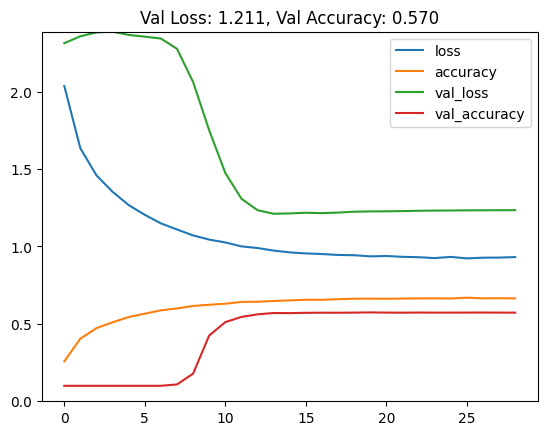

<Figure size 800x600 with 0 Axes>

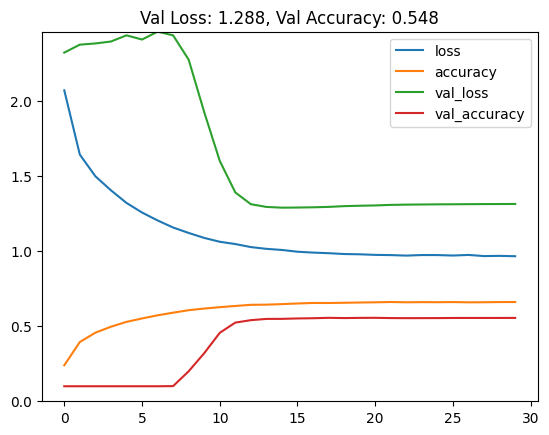

<Figure size 800x600 with 0 Axes>

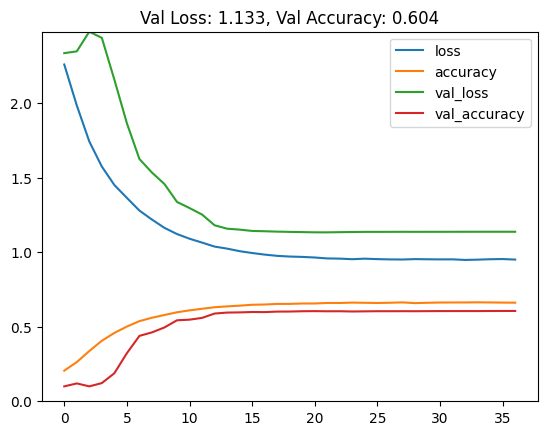

<Figure size 800x600 with 0 Axes>

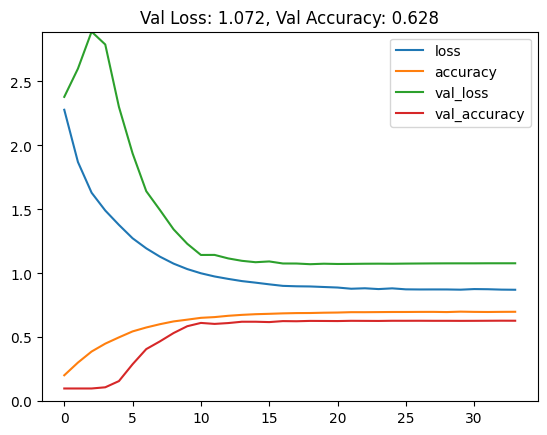

<Figure size 800x600 with 0 Axes>

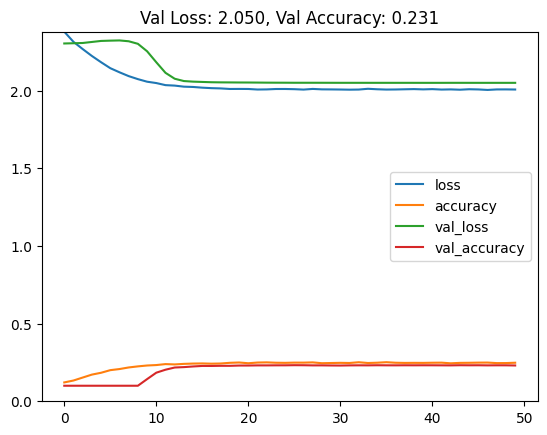

<Figure size 800x600 with 0 Axes>

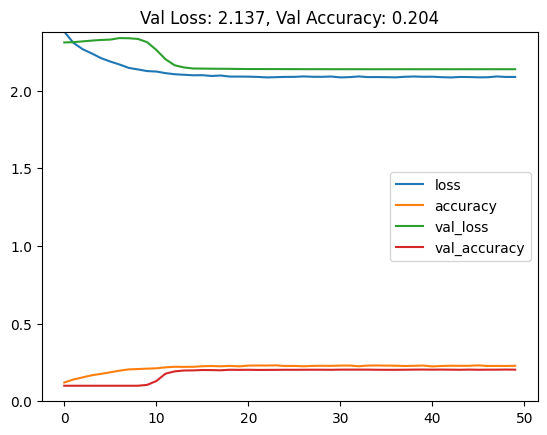

<Figure size 800x600 with 0 Axes>

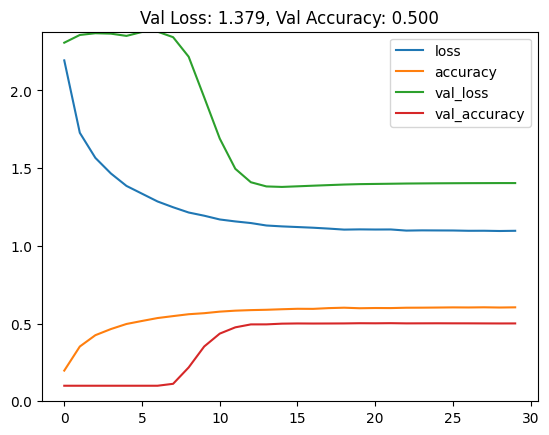

<Figure size 800x600 with 0 Axes>

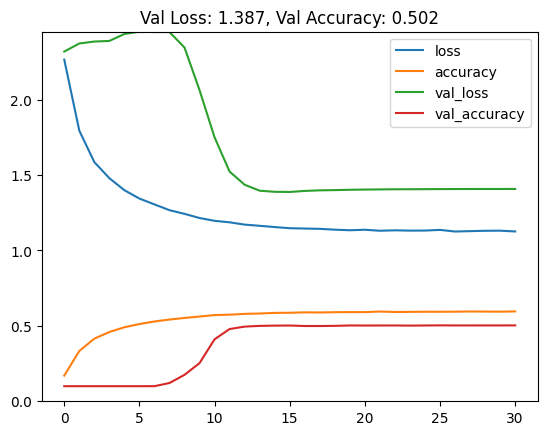

<Figure size 800x600 with 0 Axes>

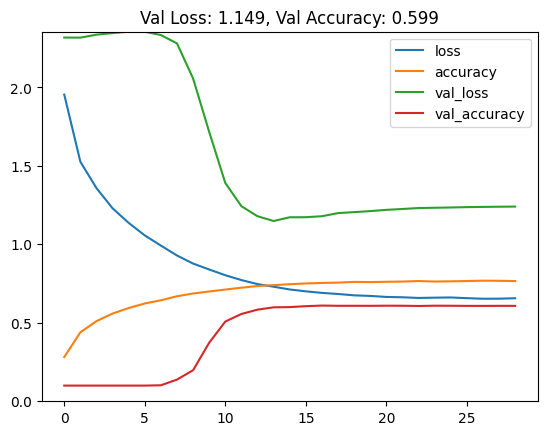

<Figure size 800x600 with 0 Axes>

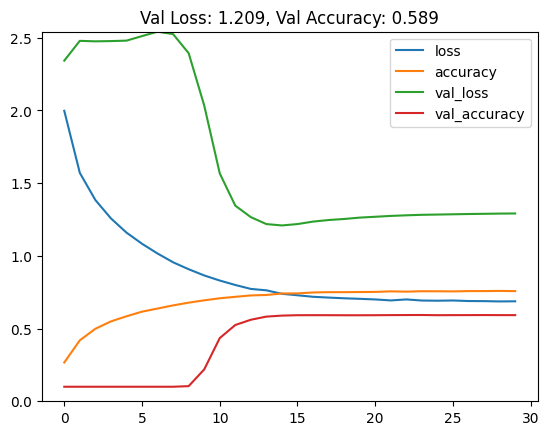

<Figure size 800x600 with 0 Axes>

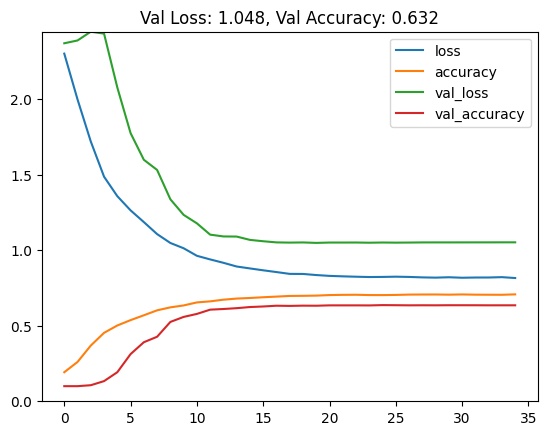

<Figure size 800x600 with 0 Axes>

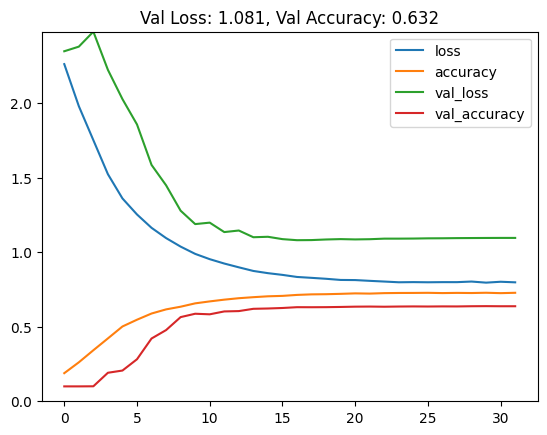

<Figure size 800x600 with 0 Axes>

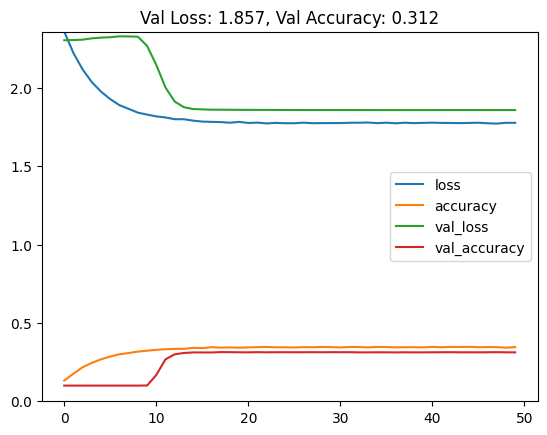

<Figure size 800x600 with 0 Axes>

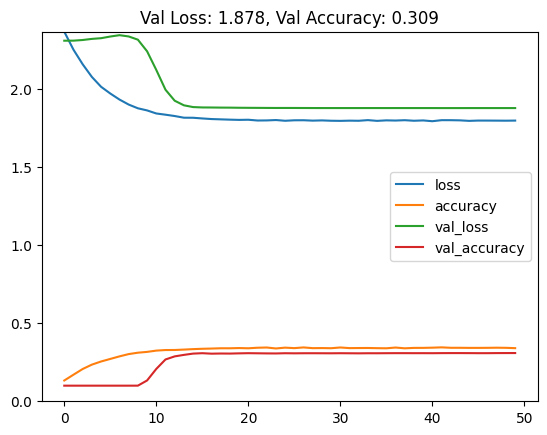

<Figure size 800x600 with 0 Axes>

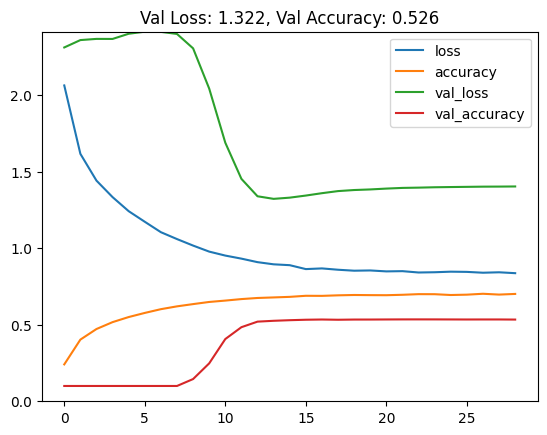

<Figure size 800x600 with 0 Axes>

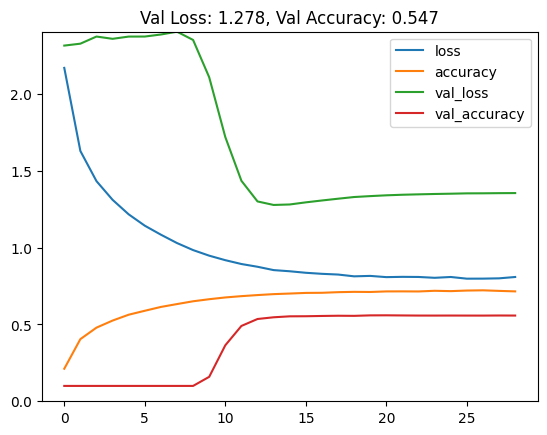

<Figure size 800x600 with 0 Axes>

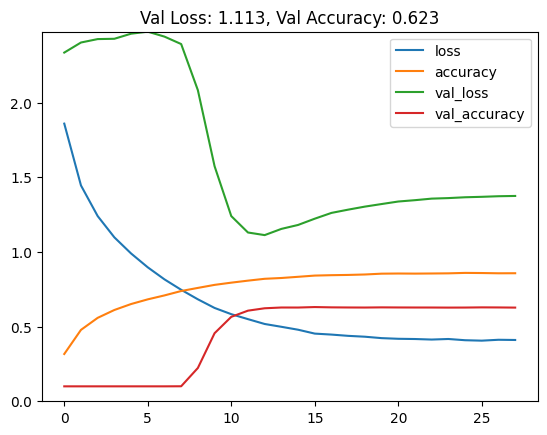

<Figure size 800x600 with 0 Axes>

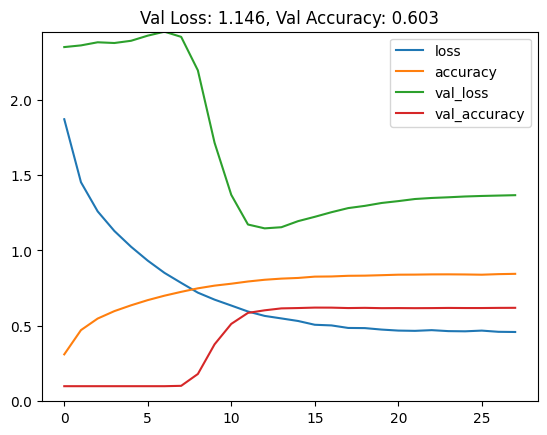

<Figure size 800x600 with 0 Axes>

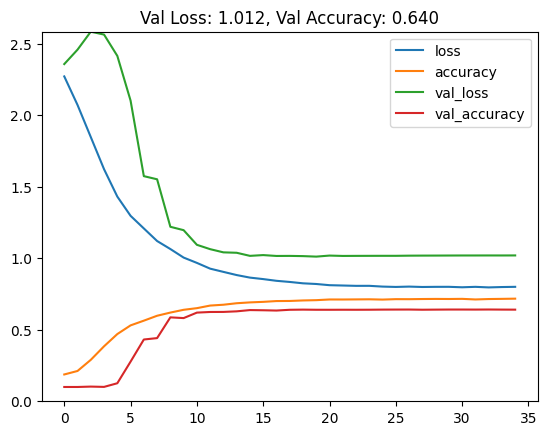

<Figure size 800x600 with 0 Axes>

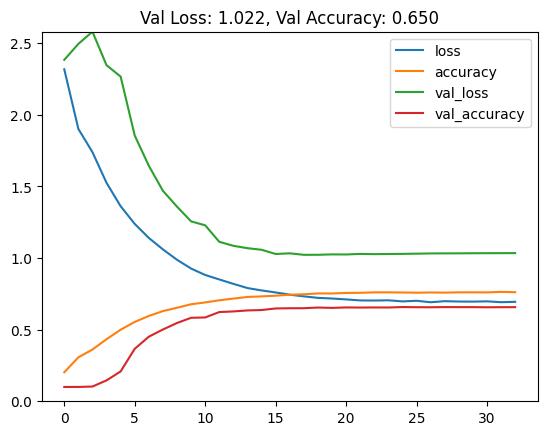

<Figure size 800x600 with 0 Axes>

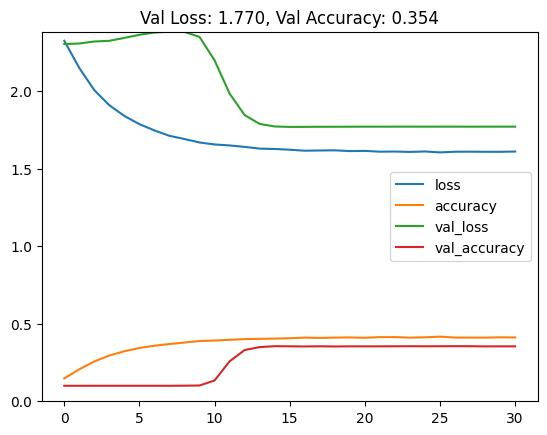

<Figure size 800x600 with 0 Axes>

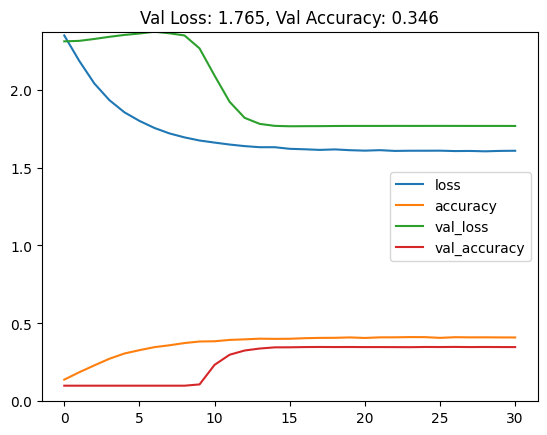

<Figure size 800x600 with 0 Axes>

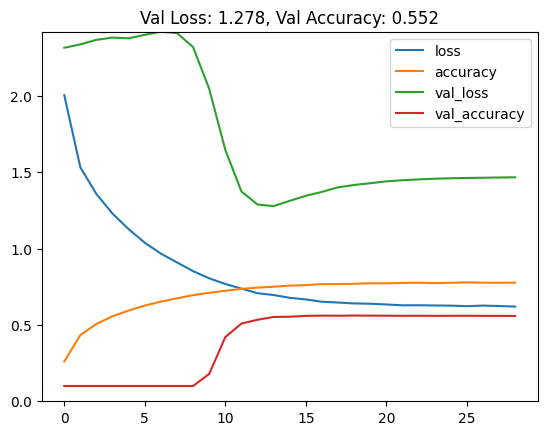

<Figure size 800x600 with 0 Axes>

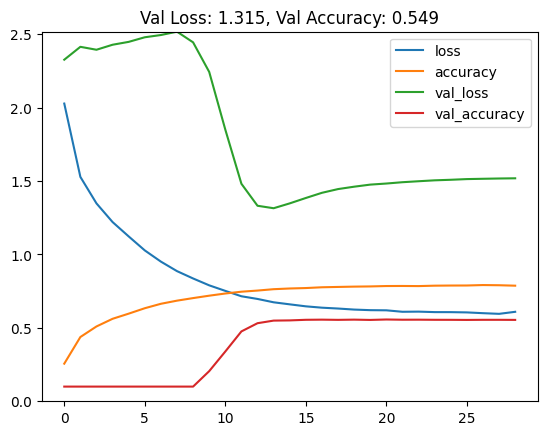

In [ ]:
gc.collect()
# Grid Search for the best hyper para setting based on my experiments and the paper recommendations.
alpli = [0.5,0.7,0.9]
lrli = [0.0005,0.00005]
mli = [0.5,0.9]
wdli = [0,0.00001]
# will get a multi dimensional array for validation loss of each trained model, each dimension
# maps to each hyper paramenter
val_loss_arr = np.zeros((len(alpli), len(lrli),len(mli),len(wdli)), dtype=np.float64)
# iterate each values to train the model
for (i, alp) in enumerate(alpli):
  for (j, lr) in enumerate(lrli):
    for (k,m) in enumerate(mli):
      for (l, wd) in enumerate(wdli):
        val_loss_arr[i,j,k,l] = hyp_tuning(alp,lr,m ,wd)
print(val_loss_arr)
with open('/content/drive/MyDrive/NarrativeTest_SharonXia/val_loss_arr.npy', 'wb') as f:
    np.save(f, val_loss_arr)

In [ ]:
print(val_loss_arr)

[[[[1.21101451 1.28836286]
   [1.13286567 1.07151711]]

  [[2.04955816 2.1374507 ]
   [1.37942076 1.38747752]]]


 [[[1.1485635  1.20919299]
   [1.04793727 1.08131278]]

  [[1.8574326  1.87823617]
   [1.32240057 1.27800679]]]


 [[[1.11254048 1.14623368]
   [1.01169467 1.02241182]]

  [[1.76953959 1.76487827]
   [1.27810693 1.31472623]]]]


From the training process graph and validation loss array, we could get some clues of good hyper paratemer. a little bit weight decay VS none depends on the other hyper parameter setting. momentum at 0.9 overperforms 0.5. Learning rate depends on other settings. For alpha, 0.7 and 0.9 are better than 0.5.

In [ ]:
# retrieve the hyper parameter setting for model which generates the minimum validation loss
ind = np.unravel_index(np.argmin(val_loss_arr, axis=None), val_loss_arr.shape)
print(val_loss_arr[ind])
print(ind)
alp = alpli[ind[0]]
lr= lrli[ind[1]]
m = mli[ind[2]]
wd = wdli[ind[3]]
print(alp, lr,m,wd)

1.0116946697235107
(2, 0, 1, 0)
0.9 0.0005 0.9 0


We have found the best hyper parameter. Let's view the training process graph.

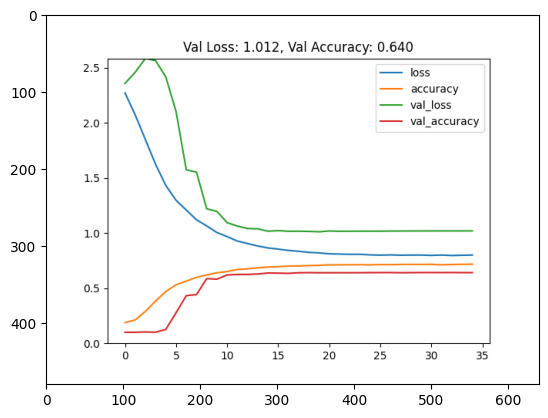

In [ ]:
parent_dir = '/content/drive/MyDrive/NarrativeTest_SharonXia/base_model_2_alpha_%.3f_lr_%.3f_m_%.2f_wd_%.6f'%(alp,lr,m,wd)
import matplotlib.image as mpimg
img = mpimg.imread(parent_dir+'.png')
plt.imshow(img)
plt.show()

It looks have converged. We do not need to retrain it. We can retrieve this model and then measure the performance using the test dataset.

In [ ]:
model_path = os.path.join(parent_dir,os.listdir(parent_dir)[-1])
print(model_path)
trained_model = tf.keras.models.load_model(model_path)
trained_model.summary()


/content/drive/MyDrive/NarrativeTest_SharonXia/base_model_2_alpha_0.900_lr_0.001_m_0.90_wd_0.000000/model.20-1.01.h5
Model: "model_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_103 (InputLayer)      [(None, 32, 32, 3)]       0         
                                                                 
 tf.math.truediv_50 (TFOpLa  (None, 32, 32, 3)         0         
 mbda)                                                           
                                                                 
 tf.math.subtract_50 (TFOpL  (None, 32, 32, 3)         0         
 ambda)                                                          
                                                                 
 mobilenetv2_0.90_32 (Funct  (None, 10)                1904954   
 ional)                                                          
                                                                 
Total p

learning rate becomes 0.001 because only 3 float point is recorded. 0.0005 becomes 0.001 in the directory

In [ ]:
# Re-evaluate the model with test dataset, preprocess is already embedded in the model
loss, accuracy  = trained_model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Test loss: 1.02
Test accuracy: 0.64


It quite makes sense due to similarity to the validation loss and accurarcy.

In [ ]:
# revert y_test to its orignal format
y_test = np.argmax(y_test,axis =1)

In [ ]:
# get the prediction labels by finding the position for the biggest probability
y_pred_prob = trained_model.predict(x_test)
y_pred = np.argmax(y_pred_prob,axis =1)

313/313 [==============================] - 2s 5ms/step


              precision    recall  f1-score   support

       plane       0.64      0.69      0.66      1000
         car       0.79      0.80      0.79      1000
        bird       0.55      0.44      0.49      1000
         cat       0.38      0.50      0.43      1000
        deer       0.58      0.58      0.58      1000
         dog       0.59      0.46      0.52      1000
        frog       0.73      0.75      0.74      1000
       horse       0.71      0.68      0.70      1000
        ship       0.77      0.77      0.77      1000
       truck       0.72      0.73      0.73      1000

    accuracy                           0.64     10000
   macro avg       0.65      0.64      0.64     10000
weighted avg       0.65      0.64      0.64     10000



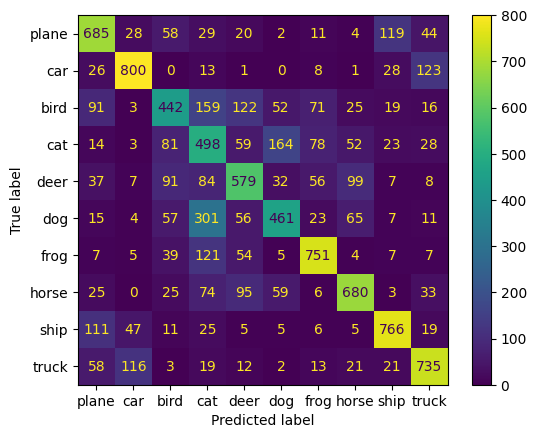

In [ ]:
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(classification_report(y_test, y_pred,target_names=classes))
# confusion matrix to display
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= classes)
disp.plot()

Here we can see the difference between different classes. We might need to do more work to improve the accuracy in bird, cat, deer, dog category. Data augmentation can be used to add more samples in these classes.

In [ ]:
def model_evaluate(model_path):
  # import data
  (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
  assert x_train.shape == (50000, 32, 32, 3)
  assert x_test.shape == (10000, 32, 32, 3)
  assert y_train.shape == (50000, 1)
  assert y_test.shape == (10000, 1)
  # load the best model
  trained_model = tf.keras.models.load_model(model_path)
  trained_model.summary()
  # model evaluation
  # get the prediction labels by finding the position for the biggest probability
  start_time= time.time()
  y_pred_prob = trained_model.predict(x_test)
  y_pred = np.argmax(y_pred_prob,axis =1)
  stop_time=time.time()
  duration =stop_time - start_time
  msec_per = duration*(10**6)/len(y_test)
  print('The inference time of the model in milliseconds per image per CPU is %.9f'%(msec_per))
  classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  print(classification_report(y_test, y_pred,target_names=classes))
  # confusion matrix to display
  cm = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= classes)
  disp.plot()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 32, 32, 3)         0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 32, 32, 3)         0         
 mbda)                                                           
                                                                 
 mobilenetv2_0.90_32 (Funct  (None, 10)                1904954   
 ional)                                                          
                                                                 
Total params: 1904954 (7.27 MB)
Trainable params: 1873610 (7.15 MB)
Non-trainable params: 31344 (122.44 KB)
_________________

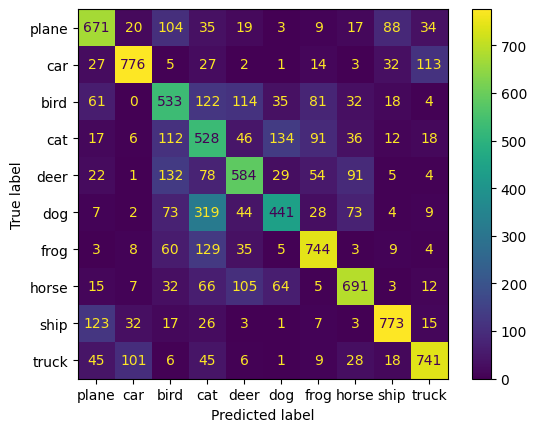

In [ ]:
model_evaluate('/content/drive/MyDrive/NarrativeTest/base_model_mobileNetV2_alpha_0.900_lr_0.0005000_m_0.90_wd_0.000000000/model.h5')

We can see model has 1904954 parameter, nearly 2M. The inference time of the model in milliseconds per text image per CPU is 1124.319529533